# Package Pricing Mission Hospital
---

## Setup

In [314]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


### Get Data

In [315]:
data = pd.read_excel('dataset/Package Pricing at Mission Hospital - Data Supplement.xlsx', sheet_name='MH-Raw Data')
data.head()

,SL.,AGE,GENDER,MARITAL STATUS,KEY COMPLAINTS -CODE,BODY WEIGHT,BODY HEIGHT,HR PULSE,BP -HIGH,BP-LOW,RR,PAST MEDICAL HISTORY CODE,HB,UREA,CREATININE,MODE OF ARRIVAL,STATE AT THE TIME OF ARRIVAL,TYPE OF ADMSN,TOTAL COST TO HOSPITAL,TOTAL LENGTH OF STAY,LENGTH OF STAY - ICU,LENGTH OF STAY- WARD,IMPLANT USED (Y/N),COST OF IMPLANT
0,1,58.0,M,MARRIED,other- heart,49.2,160,118,100.0,80.0,32,NaN,11.4,33.0,0.8,AMBULANCE,ALERT,EMERGENCY,660293.0,25,12,13,Y,38000
1,2,59.0,M,MARRIED,CAD-DVD,41.0,155,78,70.0,50.0,28,NaN,11.4,95.0,1.7,AMBULANCE,ALERT,EMERGENCY,809130.0,41,20,21,Y,39690
2,3,82.0,M,MARRIED,CAD-TVD,46.6,164,100,110.0,80.0,20,Diabetes2,11.8,15.0,0.8,WALKED IN,ALERT,ELECTIVE,362231.0,18,9,9,N,0
3,4,46.0,M,MARRIED,CAD-DVD,80.0,173,122,110.0,80.0,24,hypertension1,11.8,74.0,1.5,AMBULANCE,ALERT,EMERGENCY,629990.0,14,13,1,Y,89450
4,5,60.0,M,MARRIED,CAD-DVD,58.0,175,72,180.0,100.0,18,Diabetes2,10.0,48.0,1.9,AMBULANCE,ALERT,EMERGENCY,444876.0,24,12,12,N,0


### Data Cleaning

In [316]:
data['MARITAL STATUS'] = data['MARITAL STATUS'].str.capitalize()
data['PAST MEDICAL HISTORY CODE'] = data['PAST MEDICAL HISTORY CODE'].str.capitalize()
data['MODE OF ARRIVAL'] = data['MODE OF ARRIVAL'].str.capitalize()
data['STATE AT THE TIME OF ARRIVAL'] = data['STATE AT THE TIME OF ARRIVAL'].str.capitalize()
data['TYPE OF ADMSN'] = data['TYPE OF ADMSN'].str.capitalize()

data['AGE'] = data['AGE'].astype('int64')


In [317]:
# Finding Null Values
cols_check = [col for col in data.columns if not((col == 'PAST MEDICAL HISTORY CODE') | (col == 'KEY COMPLAINTS -CODE'))]
#data[data[cols_check].isnull().any(axis=1)]

### Data Prep

In [318]:
# Age group categories
data['AGE_GROUP'] = '50+'

age_conditions = [
    (data['AGE'] <= 10),
    ((data['AGE'] > 10) & (data['AGE'] <= 25)),
    ((data['AGE'] > 25) & (data['AGE'] <= 50))
]

age_groups = ['<10', '11-25', '26-50']

data['AGE_GROUP'] = np.select(age_conditions, age_groups, default='50+')

# Hemoglobin Categories
data['HB_LEVEL'] = np.where(
    (data['HB'].isna()) |
    ((data['GENDER'] == 'F') & (data['HB'] >= 12.5) & (data['HB'] <= 15.5)) |
    ((data['GENDER'] == 'M') & (data['HB'] >= 13) & (data['HB'] <= 17.5)), 
    'NORMAL', 'ABNORMAL')

# BP Categories
bp_conditions = [
    (data['BP -HIGH'] < 120) & (data['BP-LOW'] < 80),
    (data['BP -HIGH'] > 119) & (data['BP -HIGH'] < 130) & (data['BP-LOW'] < 80),
    ((data['BP -HIGH'] > 129) & (data['BP -HIGH'] < 140)) | ((data['BP-LOW'] > 79) & (data['BP-LOW'] < 90)),
    (data['BP -HIGH'] >= 140) | (data['BP-LOW'] >= 90),
    (data['BP -HIGH'] > 180) | (data['BP-LOW'] > 120)
]

bp_groups = ['NORMAL','ELEVATED', 'HYPERTENSION STAGE 1', 'HYPERTENSION STAGE 2', 'HYPERTENSIVE CRISIS']

data['BP_RANGE'] = np.select(bp_conditions, bp_groups, default='NORMAL')

# Urea Categories
data['UREA_CAT'] = np.where(
    (data['UREA'].isna()) |
    ((data['GENDER'] == 'F') & (data['UREA'] >= 6) & (data['UREA'] < 21)) |
    ((data['GENDER'] == 'M') & (data['UREA'] >= 7) & (data['UREA'] <= 20)), 
    'NORMAL', 'ABNORMAL'
)


# BMI Categories
# Calculate BMI
data['BMI_VALUE'] = data['BODY WEIGHT'] / (data['BODY HEIGHT']/100) ** 2

bmi_conditions = [
    (data['BMI_VALUE'] <= 18.5),
    (data['BMI_VALUE'] > 18.5) & (data['BMI_VALUE'] < 25),
    (data['BMI_VALUE'] >= 25) & (data['BMI_VALUE'] < 30),
    (data['BMI_VALUE'] >= 30)
]

bmi_groups = ['UNDERWEIGHT', 'NORMAL', 'OVERWEIGHT', 'OBESE']

data['BMI_CAT'] = np.select(bmi_conditions, bmi_groups, default='OBESE')

# Creatinine Categories
data['CREATININE_CAT'] = np.where(
    (data['CREATININE'].isna()) |
    ((data['AGE'] <= 3) & (data['CREATININE'] >= 0.3) & (data['CREATININE'] <= 0.7)) |
    ((data['AGE'] > 3) & (data['AGE'] <= 18) & (data['CREATININE'] >= 0.5) & (data['CREATININE'] <= 1.0)) |
    ((data['AGE'] > 18) & (data['GENDER'] == 'F') & (data['CREATININE'] >= 0.6) & (data['CREATININE'] <= 1.1)) |
    ((data['AGE'] > 18) & (data['GENDER'] == 'M') & (data['CREATININE'] >= 0.9) & (data['CREATININE'] <= 1.3)),
    'NORMAL',
    'ABNORMAL'
)



## Exploring Data - Univariate Analysis

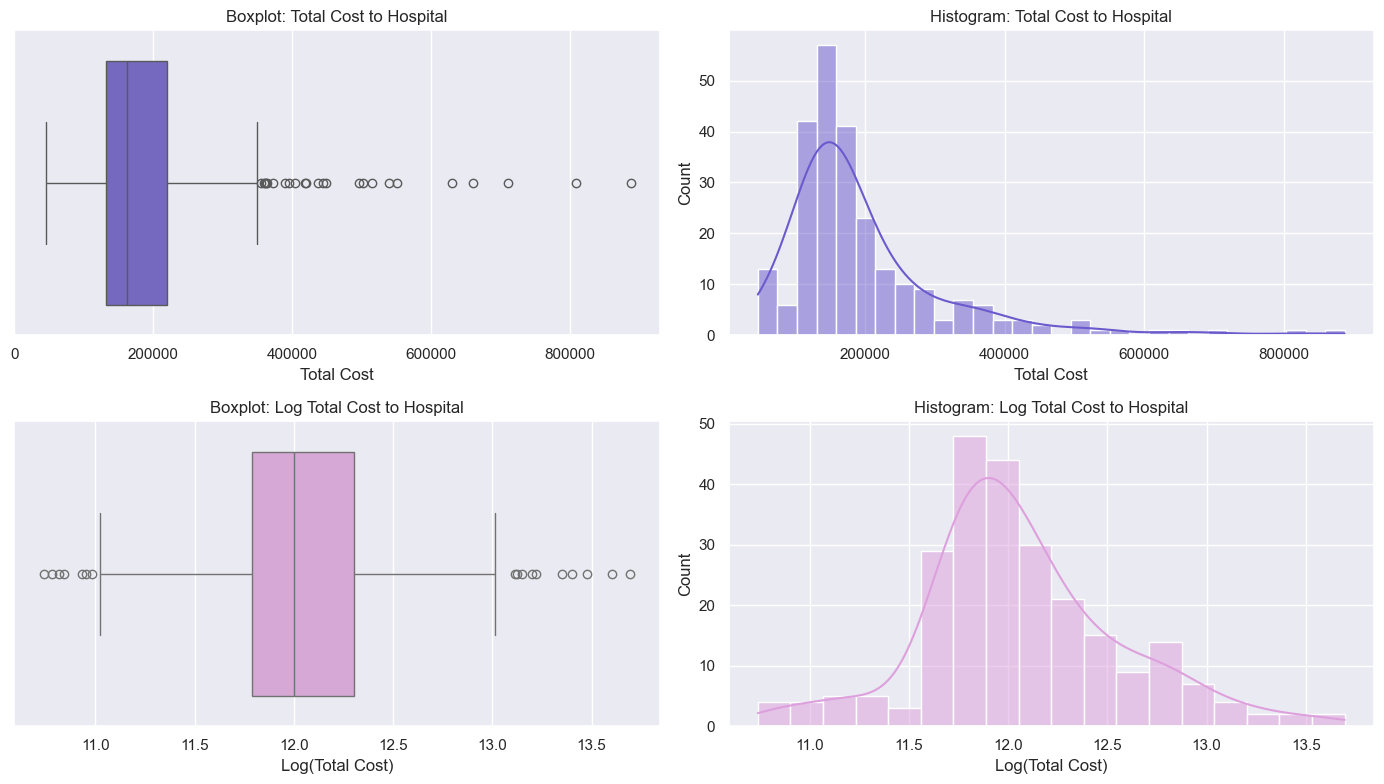

In [319]:
# Fixing right skewness by taking natural log
data['LOG_TOTAL_COST_TO_HOSPITAL'] = np.log(data['TOTAL COST TO HOSPITAL '])

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
sns.set_theme(style="darkgrid")
# Original Total Cost Boxplot
sns.boxplot(x=data['TOTAL COST TO HOSPITAL '], ax=axes[0,0], color='slateblue')
axes[0,0].set_title('Boxplot: Total Cost to Hospital')
axes[0,0].set_xlabel('Total Cost')
axes[0,0].set_xlim(left=0)  # start x-axis at 0 for better visualization

# Original Total Cost Histogram
sns.histplot(data['TOTAL COST TO HOSPITAL '], kde=True, ax=axes[0,1], color='slateblue')
axes[0,1].set_title('Histogram: Total Cost to Hospital')
axes[0,1].set_xlabel('Total Cost')

# Log-Transformed Total Cost Boxplot
sns.boxplot(x=data['LOG_TOTAL_COST_TO_HOSPITAL'], ax=axes[1,0], color='plum')
axes[1,0].set_title('Boxplot: Log Total Cost to Hospital')
axes[1,0].set_xlabel('Log(Total Cost)')

# Log-Transformed Total Cost Histogram
sns.histplot(data['LOG_TOTAL_COST_TO_HOSPITAL'], kde=True, ax=axes[1,1], color='plum')
axes[1,1].set_title('Histogram: Log Total Cost to Hospital')
axes[1,1].set_xlabel('Log(Total Cost)')

plt.tight_layout()
plt.show()

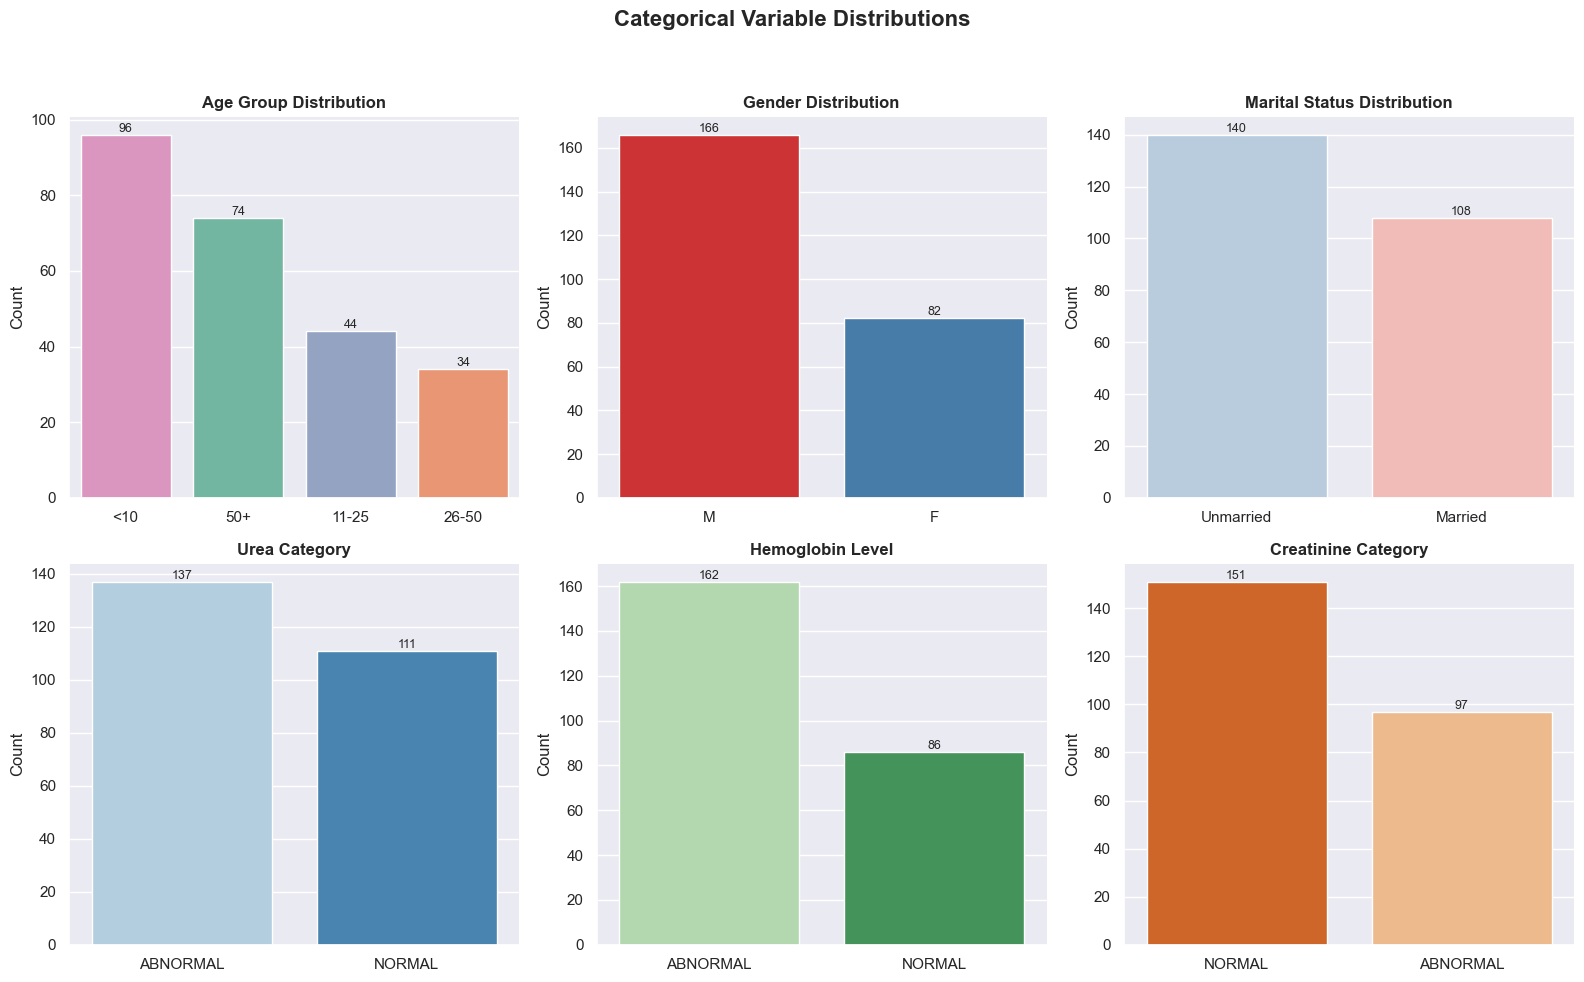

In [320]:
# Creating plots for distributions
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

categories = [
    ('AGE_GROUP', 'Age Group Distribution', 'Set2'),
    ('GENDER', 'Gender Distribution', 'Set1'),
    ('MARITAL STATUS', 'Marital Status Distribution', 'Pastel1'),
    ('UREA_CAT', 'Urea Category', 'Blues'),
    ('HB_LEVEL', 'Hemoglobin Level', 'Greens'),
    ('CREATININE_CAT', 'Creatinine Category', 'Oranges')
]

for ax, (col, title, palette) in zip(axes.flatten(), categories):
    sns.countplot(
        x=col, 
        hue=col, 
        data=data, 
        order=data[col].value_counts().index,
        palette=palette, 
        legend=False, 
        ax=ax
    )
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax.spines[['top', 'right']].set_visible(False)
    for container in ax.containers:
        ax.bar_label(container, fontsize=9)

plt.suptitle('Categorical Variable Distributions', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [321]:
# Function to return value count and frequency, as well as mean cost
def value_count_freq(col):
    val_count = col.value_counts()
    freq = col.value_counts(normalize=True) * 100
    mean_cost = data['LOG_TOTAL_COST_TO_HOSPITAL'].groupby(col).mean()
    val_concat = pd.concat([val_count, freq, mean_cost], axis=1)
    val_concat.columns = ['Count', 'Frequency (%)', 'Mean']
    return val_concat

### Statistical Tests & Variable Reduction

T Tests

In [322]:
# T Test for Gender
display(value_count_freq(data['GENDER']))
male_cost = data[data['GENDER'] == 'M']['LOG_TOTAL_COST_TO_HOSPITAL']
female_cost = data[data['GENDER'] == 'F']['LOG_TOTAL_COST_TO_HOSPITAL']
t_stat, p_value = ttest_ind(male_cost, female_cost, equal_var=False)
print("GENDER")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# T Test for Marital Status
display(value_count_freq(data['MARITAL STATUS']))
married_cost = data[data['MARITAL STATUS'] == 'Married']['LOG_TOTAL_COST_TO_HOSPITAL']
unmarried_cost = data[data['MARITAL STATUS'] == 'Unmarried']['LOG_TOTAL_COST_TO_HOSPITAL']
t_stat, p_value = ttest_ind(married_cost, unmarried_cost, equal_var=False)
print("MARITAL STATUS")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# T Test for Urea Category
display(value_count_freq(data['UREA_CAT']))
normal_cost = data[data['UREA_CAT'] == 'NORMAL']['LOG_TOTAL_COST_TO_HOSPITAL']
abnormal_cost = data[data['UREA_CAT'] == 'ABNORMAL']['LOG_TOTAL_COST_TO_HOSPITAL']
t_stat, p_value = ttest_ind(normal_cost, abnormal_cost, equal_var=False)
print("UREA LEVEL")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# T Test for HB Level
display(value_count_freq(data['HB_LEVEL']))
normal_cost = data[data['HB_LEVEL'] == 'NORMAL']['LOG_TOTAL_COST_TO_HOSPITAL']
abnormal_cost = data[data['HB_LEVEL'] == 'ABNORMAL']['LOG_TOTAL_COST_TO_HOSPITAL']
t_stat, p_value = ttest_ind(normal_cost, abnormal_cost, equal_var=False)
print("HB LEVEL")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# T Test for Creatinine Level
display(value_count_freq(data['CREATININE_CAT']))
normal_cost = data[data['CREATININE_CAT'] == 'NORMAL']['LOG_TOTAL_COST_TO_HOSPITAL']
abnormal_cost = data[data['CREATININE_CAT'] == 'ABNORMAL']['LOG_TOTAL_COST_TO_HOSPITAL']
t_stat, p_value = ttest_ind(normal_cost, abnormal_cost, equal_var=False)
print("CREATININE CATEGORY")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

,Count,Frequency (%),Mean
GENDER,,,
M,166,66.935484,12.125180
F,82,33.064516,11.934355


GENDER
T-statistic: 2.8529046932288042
P-value: 0.004891094559017045


,Count,Frequency (%),Mean
MARITAL STATUS,,,
Unmarried,140,56.451613,11.884857
Married,108,43.548387,12.291824


MARITAL STATUS
T-statistic: 6.660985844709109
P-value: 2.521738870633243e-10


,Count,Frequency (%),Mean
UREA_CAT,,,
ABNORMAL,137,55.241935,12.108387
NORMAL,111,44.758065,12.004936


UREA LEVEL
T-statistic: -1.6420852581114334
P-value: 0.10185014457722881


,Count,Frequency (%),Mean
HB_LEVEL,,,
ABNORMAL,162,65.322581,12.040969
NORMAL,86,34.677419,12.101859


HB LEVEL
T-statistic: 0.8882296929603749
P-value: 0.37570485285608823


,Count,Frequency (%),Mean
CREATININE_CAT,,,
NORMAL,151,60.887097,12.058893
ABNORMAL,97,39.112903,12.067053


CREATININE CATEGORY
T-statistic: -0.1183298722370216
P-value: 0.9059427107705136


In [323]:
# Function to run T Tests on different Key Complaints
def complaint_ttests(data, complaint_col, cost_col):
    categories = data[complaint_col].dropna().unique()
    results = []

    for cat in categories:
        group_cost = data[data[complaint_col] == cat][cost_col]
        rest_cost = data[data[complaint_col] != cat][cost_col]

        # Run T-test
        t_stat, p_value = ttest_ind(group_cost, rest_cost, equal_var=False)

        # Store results
        results.append({
            'Complaint Category': cat,
            'Count (Category)': len(group_cost),
            'Mean Cost (Category)': np.round(group_cost.mean(), 2),
            'Mean Cost (Rest)': np.round(rest_cost.mean(), 2),
            'T-statistic': np.round(t_stat, 4),
            'P-value': np.round(p_value, 4)
        })

    # Convert to DataFrame
    return pd.DataFrame(results).sort_values('P-value')

In [324]:
results_df = complaint_ttests(data, 'KEY COMPLAINTS -CODE', 'LOG_TOTAL_COST_TO_HOSPITAL')
print('Key Complaints Code')
display(results_df)
print()

results_df = complaint_ttests(data, 'PAST MEDICAL HISTORY CODE', 'LOG_TOTAL_COST_TO_HOSPITAL')
print('Past Medical History Code')
display(results_df)


Key Complaints Code


,Complaint Category,Count (Category),Mean Cost (Category),Mean Cost (Rest),T-statistic,P-value
3,RHD,26,12.38,12.02,4.6389,0.0000
1,CAD-DVD,27,12.51,12.01,4.6139,0.0001
9,OS-ASD,15,11.85,12.08,-4.4143,0.0001
2,CAD-TVD,24,12.42,12.02,3.9513,0.0005
8,ACHD,19,11.66,12.10,-3.6967,0.0013
10,PM-VSD,6,11.88,12.07,-3.2339,0.0085
5,other- respiratory,15,11.83,12.08,-1.9315,0.0712
0,other- heart,55,12.00,12.08,-0.9601,0.3398
7,other-tertalogy,18,12.02,12.07,-0.9379,0.3525
6,other-nervous,3,11.89,12.06,-0.5705,0.6248



Past Medical History Code


,Complaint Category,Count (Category),Mean Cost (Category),Mean Cost (Rest),T-statistic,P-value
0,Diabetes2,9,12.79,12.03,5.2178,0.0006
1,Hypertension1,23,12.37,12.03,3.4441,0.0018
5,Other,15,11.75,12.08,-2.8256,0.0119
3,Hypertension2,13,11.89,12.07,-2.2494,0.0379
4,Diabetes1,10,12.31,12.05,1.4337,0.1833
2,Hypertension3,5,12.26,12.06,0.8214,0.4561


ANOVA

In [325]:
# Anova helper function
def run_anova(data, group_col, value_col):
    categories = data[group_col].dropna().unique()
    groups = [data[data[group_col] == cat][value_col] for cat in categories]

    f_stat, p_value = f_oneway(*groups)

    print(f"ANOVA Results ---> {group_col}:")
    print(f"F-statistic: {f_stat:.4f}")
    print(f"P-value: {p_value:.4e}")
    print()

In [326]:
run_anova(data, 'KEY COMPLAINTS -CODE', 'LOG_TOTAL_COST_TO_HOSPITAL')
run_anova(data, 'AGE_GROUP', 'LOG_TOTAL_COST_TO_HOSPITAL')
run_anova(data, 'BP_RANGE', 'LOG_TOTAL_COST_TO_HOSPITAL')
run_anova(data, 'BMI_CAT', 'LOG_TOTAL_COST_TO_HOSPITAL')

ANOVA Results ---> KEY COMPLAINTS -CODE:
F-statistic: 7.1001
P-value: 1.0247e-10

ANOVA Results ---> AGE_GROUP:
F-statistic: 18.9332
P-value: 4.5096e-11

ANOVA Results ---> BP_RANGE:
F-statistic: 4.1825
P-value: 6.5419e-03

ANOVA Results ---> BMI_CAT:
F-statistic: 11.6216
P-value: 3.8094e-07



## Data Prep Pipeline

In [327]:
# Features: Age group, gender, marital status, BP range, BMI category, CAD-TVD, CAD-DVD, RHD, ACHD, OS-ASD, PM-VSD, Diabetes2, Hypertension1
features = ['AGE_GROUP', 'GENDER', 'BP_RANGE', 'MARITAL STATUS', 'BMI_CAT', 'KEY COMPLAINTS -CODE', 'PAST MEDICAL HISTORY CODE']

# Keeping significant complaint and history categories
sig_complaints = ['CAD-DVD', 'CAD_TVD','RHD','ACHD', 'OS-ASD', 'PM-VSD']
sig_histories = ['Diabetes2', 'Hypertension1']

data_model = data.copy()

# Set insignificant categories to 'Other'
data_model['KEY COMPLAINTS -CODE'] = data_model['KEY COMPLAINTS -CODE'].apply(
    lambda x: x if x in sig_complaints else 'Other'
)

data_model['PAST MEDICAL HISTORY CODE'] = data_model['PAST MEDICAL HISTORY CODE'].apply(
    lambda x: x if x in sig_histories else 'Other'
)

# One-Hot Encoding
X = pd.get_dummies(data_model[features], drop_first=True)

# Target variable
y = data_model['LOG_TOTAL_COST_TO_HOSPITAL']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Linear Regression Baseline Model

In [328]:
# Model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict
y_pred_lr = lr.predict(X_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2 = r2_score(y_test, y_pred_lr)

print(f"Linear Regression RMSE: {rmse:.4f}")
print(f"Linear Regression R^2: {r2:.4f}")

Linear Regression RMSE: 0.4149
Linear Regression R^2: 0.2557


### Feature Importance

In [329]:
# Feature importance
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr.coef_
}).sort_values(by='Coefficient', ascending=False)

display(coef_df)

,Feature,Coefficient
15,KEY COMPLAINTS -CODE_RHD,0.746977
11,KEY COMPLAINTS -CODE_CAD-DVD,0.565241
1,AGE_GROUP_50+,0.526858
14,KEY COMPLAINTS -CODE_PM-VSD,0.309567
12,KEY COMPLAINTS -CODE_OS-ASD,0.301681
0,AGE_GROUP_26-50,0.294743
13,KEY COMPLAINTS -CODE_Other,0.283893
3,GENDER_M,0.097082
7,MARITAL STATUS_Unmarried,0.079339
10,BMI_CAT_UNDERWEIGHT,0.059143


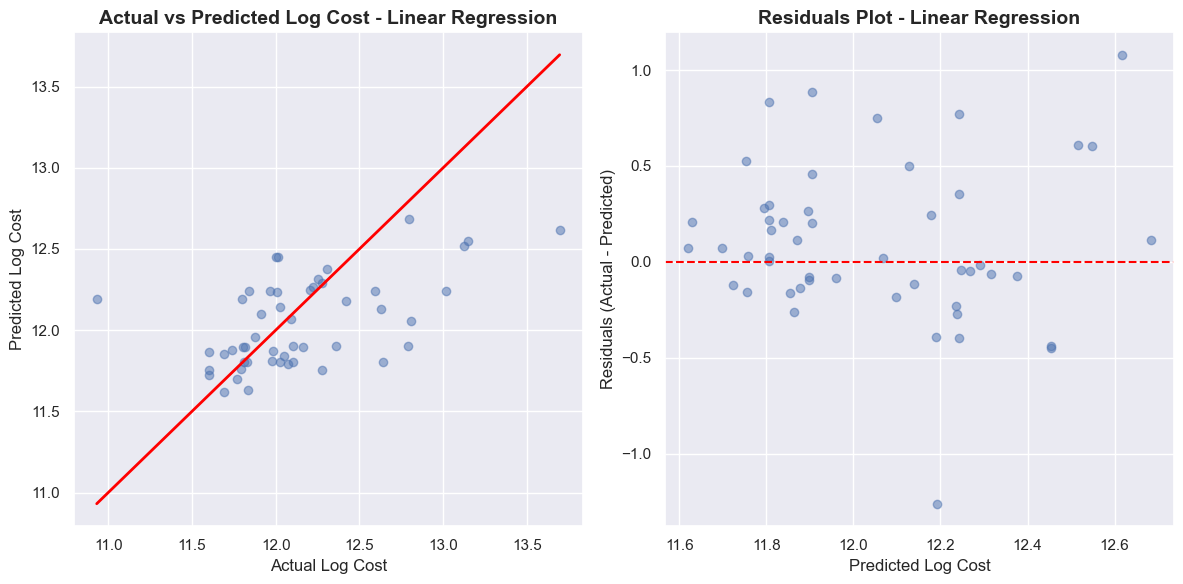

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Actual vs Predicted
axes[0].scatter(y_test, y_pred_lr, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
axes[0].set_xlabel('Actual Log Cost')
axes[0].set_ylabel('Predicted Log Cost')
axes[0].set_title('Actual vs Predicted Log Cost - Linear Regression', fontsize=14, fontweight='bold')

# Residuals plot
residuals = y_test - y_pred_lr
axes[1].scatter(y_pred_lr, residuals, alpha=0.5)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_xlabel('Predicted Log Cost')
axes[1].set_ylabel('Residuals (Actual - Predicted)')
axes[1].set_title('Residuals Plot - Linear Regression', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## Lasso

In [331]:
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train, y_train)

y_pred_lasso = lasso.predict(X_test)

print("Lasso RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lasso)))
print("Lasso R^2:", r2_score(y_test, y_pred_lasso))

Lasso RMSE: 0.4158516574441663
Lasso R^2: 0.25221241655901183


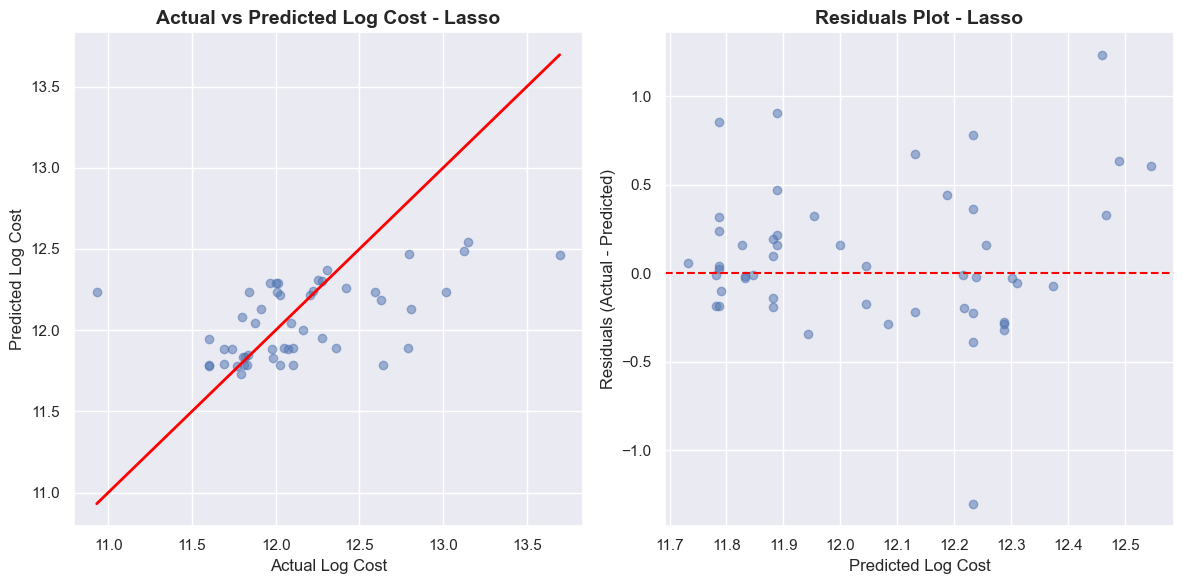

In [332]:
# Lasso plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Actual vs Predicted
axes[0].scatter(y_test, y_pred_lasso, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
axes[0].set_xlabel('Actual Log Cost')
axes[0].set_ylabel('Predicted Log Cost')
axes[0].set_title('Actual vs Predicted Log Cost - Lasso', fontsize=14, fontweight='bold')

# Residuals plot 
residuals_lasso = y_test - y_pred_lasso
axes[1].scatter(y_pred_lasso, residuals_lasso, alpha=0.5)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_xlabel('Predicted Log Cost')
axes[1].set_ylabel('Residuals (Actual - Predicted)')
axes[1].set_title('Residuals Plot - Lasso', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


## Random Forest Regressor

In [333]:
rf = RandomForestRegressor(random_state=42, n_estimators=100)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

# Evaluate
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest RMSE: {rmse_rf:.4f}")
print(f"Random Forest R^2: {r2_rf:.4f}")

importances = rf.feature_importances_
feat_imp = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values('Importance', ascending=False)
display(feat_imp)


Random Forest RMSE: 0.4359
Random Forest R^2: 0.1785


,Feature,Importance
7,MARITAL STATUS_Unmarried,0.177270
1,AGE_GROUP_50+,0.102980
15,KEY COMPLAINTS -CODE_RHD,0.092289
10,BMI_CAT_UNDERWEIGHT,0.086888
3,GENDER_M,0.075750
9,BMI_CAT_OVERWEIGHT,0.066812
13,KEY COMPLAINTS -CODE_Other,0.060349
17,PAST MEDICAL HISTORY CODE_Other,0.053542
2,AGE_GROUP_<10,0.044197
6,BP_RANGE_NORMAL,0.042433


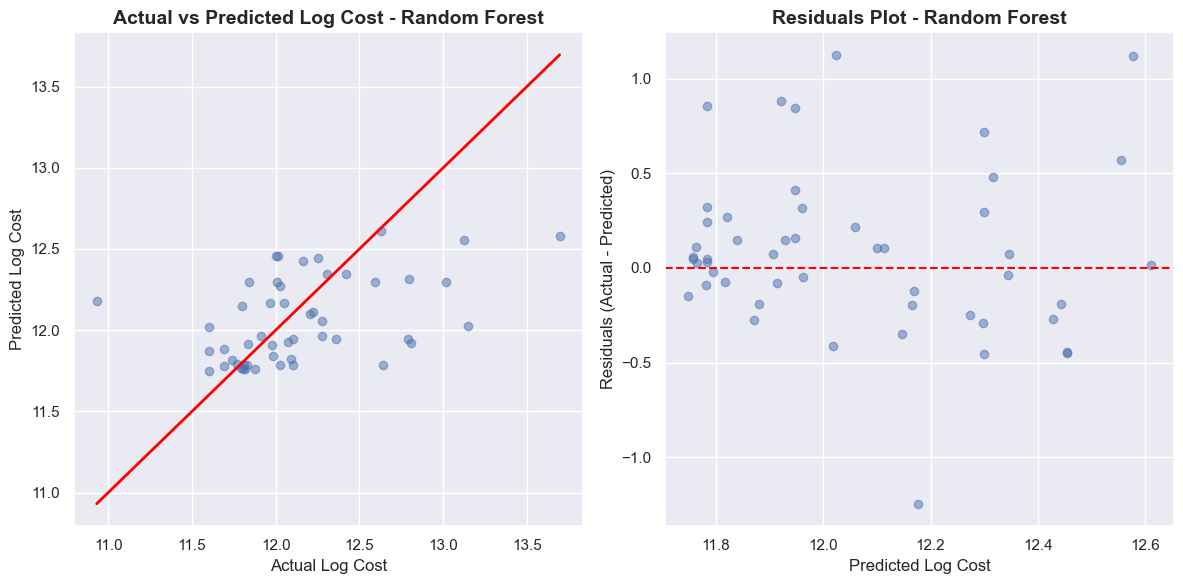

In [334]:
# Plots for Random Forest
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Actual vs Predicted for Random Forest
axes[0].scatter(y_test, y_pred_rf, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
axes[0].set_xlabel('Actual Log Cost')
axes[0].set_ylabel('Predicted Log Cost')
axes[0].set_title('Actual vs Predicted Log Cost - Random Forest', fontsize=14, fontweight='bold')

# Residuals plot for Random Forest
residuals_rf = y_test - y_pred_rf
axes[1].scatter(y_pred_rf, residuals_rf, alpha=0.5)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_xlabel('Predicted Log Cost')
axes[1].set_ylabel('Residuals (Actual - Predicted)')
axes[1].set_title('Residuals Plot - Random Forest', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


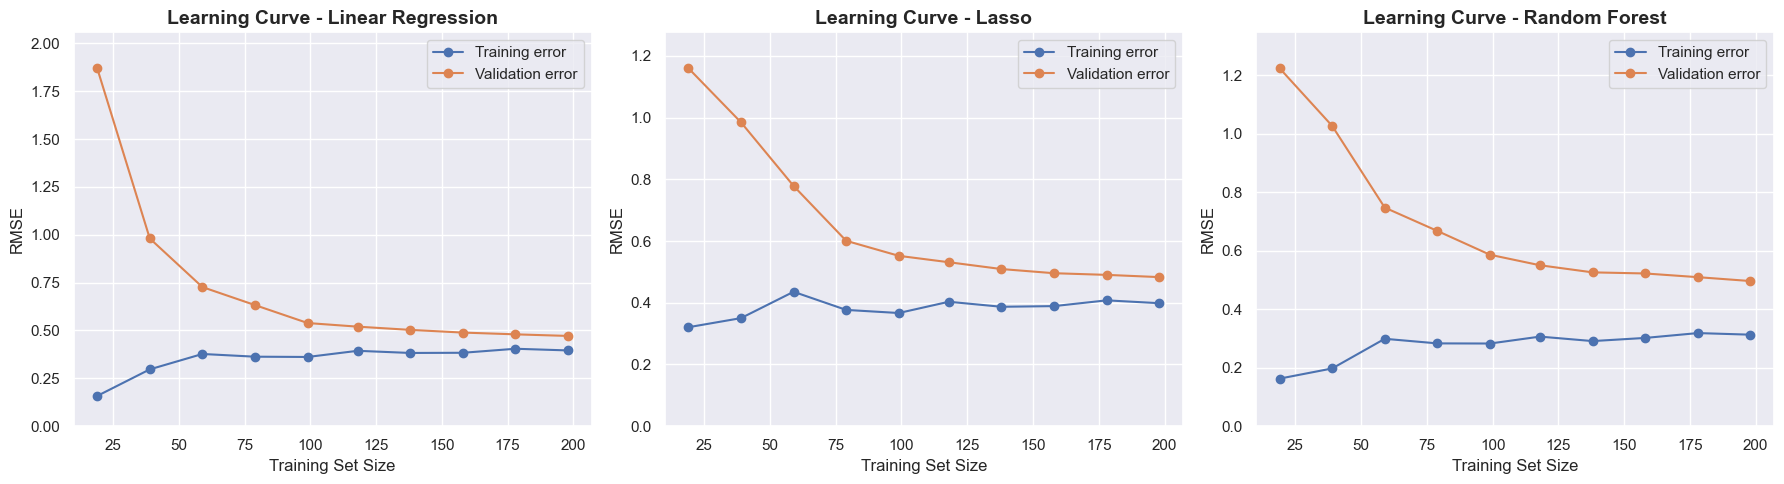

In [336]:

from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

models = {
    'Linear Regression': lr,
    'Lasso': lasso,
    'Random Forest': rf
}

plt.figure(figsize=(18, 5))

for i, (name, model) in enumerate(models.items(), 1):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='neg_root_mean_squared_error',
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=42)
    
    train_scores_mean = -train_scores.mean(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)
    
    plt.subplot(1, 3, i)
    plt.plot(train_sizes, train_scores_mean, 'o-', label='Training error')
    plt.plot(train_sizes, test_scores_mean, 'o-', label='Validation error')
    plt.title(f'Learning Curve - {name}', fontsize=14, fontweight='bold')
    plt.xlabel('Training Set Size')
    plt.ylabel('RMSE')
    plt.ylim(0, max(max(train_scores_mean), max(test_scores_mean)) * 1.1)
    plt.legend()

plt.tight_layout()
plt.show()
